# FEM-BEM coupling of Poisson-Boltzmann - spherical domain

In [1]:
import numpy as np
from mpi4py import MPI
from dolfinx.fem import FunctionSpace
from dolfinx.mesh import create_unit_square, create_unit_cube
from dolfinx.geometry import (BoundingBoxTree, compute_colliding_cells,
                              compute_collisions)


def get_local_coordinates(vertices, point):
    """Get the local coordinates of the point in the cell."""
    origin = vertices[0]
    axes = [v - origin for v in vertices[1:]]
    tdim = 3
    if len(axes) == 2:
        axes.append(np.cross(axes[0], axes[1]))
        tdim = 2

    assert len(axes) == 3


    return np.linalg.solve(np.array(axes).T, point - origin)[:tdim]


def assemble_point_sources(space, points, weights):
    vector = np.zeros(space.dofmap.index_map.size_global)

    mesh = space.mesh
    for point, weight in zip(points, weights):
        # Get cell
        tree = BoundingBoxTree(mesh, mesh.geometry.dim)
        cell_candidates = compute_collisions(tree, point)
        # This gets the first cell. Would it be better to put a fraction of the delta function into each cell instead?
        cell = compute_colliding_cells(mesh, cell_candidates, point)[0]

        # Get local coordinates
        # Note: this currently only works for affine triangles and tetrahedra
        v = [mesh.geometry.x[i] for i in mesh.geometry.dofmap.links(cell)]
        local_coordinates = get_local_coordinates(v, point)

        # Note: this currently only works for scalar-valued elements that use an identity push forward map
        values = space.element.basix_element.tabulate(0, [local_coordinates])[0, 0, :, 0]
        dofs = space.dofmap.cell_dofs(cell)

        for d, v in zip(dofs, values):
            vector[d] += v * weight

    return vector


def test_point_sources_triangle():
    points = np.array([(1/4, 1/6, 0), (1/10, 6/10, 0)])

    mesh = create_unit_square(MPI.COMM_WORLD, 2, 2)
    space = FunctionSpace(mesh, ("Lagrange", 1))

    vector = assemble_point_sources(space, points, [1, 1])

    a = [i for i in vector]
    a.sort()
    assert np.isclose(a[-1], 4/5)
    assert np.isclose(a[-2], 1/2)
    assert np.isclose(a[-3], 1/3)
    assert np.isclose(a[-4], 1/5)
    assert np.isclose(a[-5], 1/6)
    assert np.isclose(a[-6], 0)
    assert np.isclose(a[0], 0)

    vector = assemble_point_sources(space, points, [2, 1])

    a = [i for i in vector]
    a.sort()
    assert np.isclose(a[-1], 1)
    assert np.isclose(a[-2], 4/5)
    assert np.isclose(a[-3], 2/3)
    assert np.isclose(a[-4], 1/3)
    assert np.isclose(a[-5], 1/5)
    assert np.isclose(a[-6], 0)
    assert np.isclose(a[0], 0)


def test_point_sources_tetrahedron():
    points = np.array([(1/4, 1/6, 0), (1/2, 1/2, 15/16)])

    mesh = create_unit_cube(MPI.COMM_WORLD, 2, 2, 2)
    space = FunctionSpace(mesh, ("Lagrange", 1))

    vector = assemble_point_sources(space, points, [1, 1])

    a = [i for i in vector]
    a.sort()
    assert np.isclose(a[-1], 7/8)
    assert np.isclose(a[-2], 1/2)
    assert np.isclose(a[-3], 1/3)
    assert np.isclose(a[-4], 1/6)
    assert np.isclose(a[-5], 1/8)
    assert np.isclose(a[-6], 0)
    assert np.isclose(a[0], 0)


    mesh = create_unit_cube(MPI.COMM_WORLD, 2, 2, 2)
    space = FunctionSpace(mesh, ("Lagrange", 1))

    vector = assemble_point_sources(space, points, [2, 1])

    a = [i for i in vector]
    a.sort()
    assert np.isclose(a[-1], 1)
    assert np.isclose(a[-2], 7/8)
    assert np.isclose(a[-3], 2/3)
    assert np.isclose(a[-4], 1/3)
    assert np.isclose(a[-5], 1/8)
    assert np.isclose(a[-6], 0)
    assert np.isclose(a[0], 0)

## Solving problems for each of the mesh

In [2]:
from mpi4py import MPI 
from dolfinx.mesh import create_unit_cube

def poisson_boltzman_jn_const(mesh):
    
    nor = ufl.FacetNormal(mesh) 
    
    # Spaces for FEM and BEM #
    fenics_space = FunctionSpace(mesh, ("Lagrange", 1))
    trace_space, trace_matrix = \
    fenicsx.fenics_to_bempp_trace_data(fenics_space)
    bempp_space = bempp.api.function_space(trace_space.grid, "P", 1)

    # Mesh size information #
    fem_size = fenics_space.dofmap.index_map.size_global
    print("FEM dofs: {0}".format(fem_size))
    print("BEM dofs: {0}".format(bempp_space.global_dof_count))
    hmax = trace_space.grid.maximum_element_diameter
    # print(hmax)
    
    # Starting set-up time
    start = time.time()     
    
    # FEM discrete variables
    u = ufl.TrialFunction(fenics_space)
    v = ufl.TestFunction(fenics_space)
        
    # BEM operators
    id_op = bempp.api.operators.boundary.sparse.identity(trace_space, bempp_space, bempp_space)
    mass = bempp.api.operators.boundary.sparse.identity(bempp_space, bempp_space, trace_space)
    
    if fmm:
        dlp_0 = bempp.api.operators.boundary.laplace.double_layer(trace_space, bempp_space, bempp_space, assembler="fmm")
        slp_0 = bempp.api.operators.boundary.laplace.single_layer(bempp_space, bempp_space, bempp_space, assembler="fmm")

        dlp = bempp.api.operators.boundary.modified_helmholtz.double_layer(trace_space, bempp_space, bempp_space, w, assembler="fmm")
        slp = bempp.api.operators.boundary.modified_helmholtz.single_layer(bempp_space, bempp_space, bempp_space, w, assembler="fmm")
    else:
        dlp_0 = bempp.api.operators.boundary.laplace.double_layer(trace_space, bempp_space, bempp_space)
        slp_0 = bempp.api.operators.boundary.laplace.single_layer(bempp_space, bempp_space, bempp_space)

        dlp = bempp.api.operators.boundary.modified_helmholtz.double_layer(trace_space, bempp_space, bempp_space, w)
        slp = bempp.api.operators.boundary.modified_helmholtz.single_layer(bempp_space, bempp_space, bempp_space, w)

    ######################### Matrix and RHS ##################################
    
    # RHS for FEM
    # rhs_fem = np.zeros(fem_size)
    # rhs_f = dolfin.Constant(0.0)
    # rhs_fem = dolfinx.fem.assemble_vector(rhs_f*v*dolfin.dx) 
    # rhs_fem.assemble()
    # ############### POINTSOURCE HAS BEEN REMOVED ################################ 
    # for i in range(len(self._points)):
    #     delta = dolfinx.PointSource(self._fenics_space, dolfinx.Point(self._points[i]), self._charges[i]/self._epsilon_s) #
    #     delta.apply(self._rhs_fem)
        
    rhs_fem = assemble_point_sources(fenics_space, PC, Q/em)
    # print(np.array(rhs_fem))
        
    # RHS for BEM
    rhs_bem = np.zeros(bempp_space.global_dof_count)
    # Global RHS
    rhs = np.concatenate([rhs_fem, rhs_bem])
    
    blocks = [[None,None],[None,None]]
    
    # FEM matrices
    trace_op = LinearOperator(trace_matrix.shape, lambda x:trace_matrix*x)

    A = fenicsx.FenicsOperator((ufl.inner(ufl.nabla_grad(u),
                                     ufl.nabla_grad(v)) ) * ufl.dx)  
    # A.assemble()
    # ai, aj, av = A.getValuesCSR()
    # A_fem = csr_matrix((av, aj, ai))
        
    # Blocked matrix
    blocks[0][0] = A.weak_form()
    blocks[0][1] = -trace_matrix.T * mass.weak_form().to_sparse()
    blocks[1][0] = (.5 * id_op - dlp).weak_form() * trace_op
    blocks[1][1] = slp.weak_form()*(em/es)

    blocked = BlockedDiscreteOperator(np.array(blocks))
    
    ######################### Preconditioner and solvers ##################################
    from scipy.sparse import diags
    
    # Diagonal Scaling #
    P1 = diags(1./blocked[0,0].to_sparse().diagonal())

    # Mass matrix preconditioner #
    P2 = InverseSparseDiscreteBoundaryOperator(
        bempp.api.operators.boundary.sparse.identity(
            bempp_space, bempp_space, bempp_space).weak_form())

    # Create a block diagonal preconditioner object using the Scipy LinearOperator class
    def apply_prec(x):
        """Apply the block diagonal preconditioner"""
        m1 = P1.shape[0]
        m2 = P2.shape[0]
        n1 = P1.shape[1]
        n2 = P2.shape[1]

        res1 = P1.dot(x[:n1]) 
        res2 = P2.dot(x[n1:])
        return np.concatenate([res1, res2])

    p_shape = (P1.shape[0] + P2.shape[0], P1.shape[1] + P2.shape[1])
    P = LinearOperator(p_shape, apply_prec, dtype=np.dtype('float64'))
        
    end = time.time()
    set_time = (end - start) 
    

    from scipy.sparse.linalg import gmres
    start = time.time()     
    soln, info = gmres(blocked, rhs, M=P, callback=count_iterations, tol=tol, restrt=500)  
    end = time.time()
    solv_time = (end - start) 
    
    soln_fem = soln[:fem_size]
    soln_bem = soln[fem_size:]

#     print("Number of iterations: {0}".format(it_count))
#     iter_num.append(it_count)
    
    u = dolfinx.fem.Function(fenics_space)
    # fem_size = fenics_space.dofmap.index_map.size_global
    u.vector.setValues(list(range(0,fem_size)), np.ascontiguousarray(soln_fem))
    dirichlet_data = trace_matrix * soln_fem
    dirichlet_fun = bempp.api.GridFunction(trace_space, coefficients=dirichlet_data)
    neumann_fun = bempp.api.GridFunction(bempp_space, coefficients=soln_bem)
    
    ######################### Solvation energy ##################################
    
    slpF = bempp.api.operators.potential.laplace.single_layer(bempp_space, np.transpose(PC)) 
    dlpF = bempp.api.operators.potential.laplace.double_layer(trace_space, np.transpose(PC))

    uF = slpF * neumann_fun - dlpF * dirichlet_fun

    q_uF = 0
    for i in range(len(PC)):
        Sum = (uF[0][i].real)*Q[i]
        q_uF = q_uF + Sum

    E_Solv = 0.5*4.*np.pi*332.064*(q_uF) 
    
    print('Energia de Solvatacion : {:7.3f} [kCal/mol]'.format(E_Solv))
    
    return E_Solv, hmax, iter_num, set_time, solv_time

In [3]:
import dolfinx
import dolfinx.io
import dolfinx.geometry
from petsc4py import PETSc
import ufl
from scipy.sparse import csr_matrix

import bempp.api
from bempp.api.external import fenicsx
# from dolfin_utils.meshconvert import meshconvert
import numpy as np
# from bempp.api.external import fenics
# from scipy.sparse.linalg import cg, minres
import pylab as plt
import time

from scipy.sparse.linalg import gmres
from scipy.sparse.linalg import LinearOperator
from bempp.api.assembly.discrete_boundary_operator import InverseSparseDiscreteBoundaryOperator
from bempp.api.assembly.blocked_operator import BlockedDiscreteOperator

from bempp.api.operators.boundary import sparse, laplace, modified_helmholtz
from bempp.api.operators.potential import laplace as lp

bempp.api.set_logging_level(level='info')
 
# Solver data #
tol = 1e-06         # Tolerance
fmm = 0             # Use FMM

# Problem data #
from readpqr_all import readpqr_all
[PC, Q, R] = readpqr_all('./arginine/arg.pqr')         # Charges, Points of charges and Radiuses
w = 0.1250                                             # kappa
es = 80.                                               # External permitivity (solvant)
em = 4.                                                # Internal permitivity (molecule)

ec = 1.602176e-19 #[C]
kb = 1.380648e-23 #[J/K]
T  = 300 #[K]
S1 = 1 #(ec/(kb*T))  #38.681 [C/J]

# Result collecting lists #
solv_error = []
mesh_size = []
iter_num = []
time_solve = []
time_set = []

# Iteratotion for mesh #
grid_size = [2, 4, 8, 16] 

it_count = 0
def count_iterations(x):
    global it_count
    it_count += 1

for m in grid_size:
    ######################### Mesh and spaces ##################################
    mesh_file = "./arginine/arg_d0"+format(m)+"_11-converted.xdmf"
    with dolfinx.io.XDMFFile(MPI.COMM_WORLD, mesh_file, "r") as xdmf:
        mesh = xdmf.read_mesh(name="Grid")
        it_count = 0
        E_Solv, hmax, iter_num, set_time, solv_time = poisson_boltzman_jn_const(mesh)
        time_set.append(set_time) 
        time_solve.append(solv_time)   
        bempp.api.log(
            "gmres finished in %i iterations and took %.2E sec." % (it_count, solv_time))
        # print("Number of iterations: {0}".format(it_count))
        iter_num.append(it_count)
        mesh_size.append(hmax)   
        
        #### Just saving the solution
        solv_error.append(E_Solv)  

INFO:bempp:Created grid with id be4b3446-ef04-448d-bd0d-6ea5fd6e9fbf. Elements: 802. Edges: 1203. Vertices: 403


FEM dofs: 972
BEM dofs: 403


INFO:bempp:OpenCL CPU Device set to: pthread-Intel(R) Core(TM) i7-6567U CPU @ 3.30GHz
  warn("Non-empty compiler output encountered. Set the "

  warn('splu converted its input to CSC format', SparseEfficiencyWarning)

INFO:bempp:gmres finished in 241 iterations and took 3.95E-01 sec.
INFO:bempp:Created grid with id 44667500-ac3b-4c0a-a72f-db0f24f62511. Elements: 1646. Edges: 2469. Vertices: 825


Energia de Solvatacion : -26.654 [kCal/mol]
FEM dofs: 2187
BEM dofs: 825


INFO:bempp:gmres finished in 217 iterations and took 7.06E-01 sec.


Energia de Solvatacion : -25.502 [kCal/mol]


INFO:bempp:Created grid with id 838067bc-531c-4aad-b3b6-248b0617058f. Elements: 3140. Edges: 4710. Vertices: 1572


FEM dofs: 4003
BEM dofs: 1572


INFO:bempp:gmres finished in 274 iterations and took 2.08E+00 sec.


Energia de Solvatacion : -24.398 [kCal/mol]


INFO:bempp:Created grid with id 52098bbc-3ef1-404a-8aea-dccbdbeb8899. Elements: 6520. Edges: 9780. Vertices: 3262


FEM dofs: 8190
BEM dofs: 3262


INFO:bempp:gmres finished in 204 iterations and took 6.02E+00 sec.


Energia de Solvatacion : -24.066 [kCal/mol]


## Ploting the results and saving for comparison to BEM-BEM and FEM-BEM coupling formulations

## Convergence plot

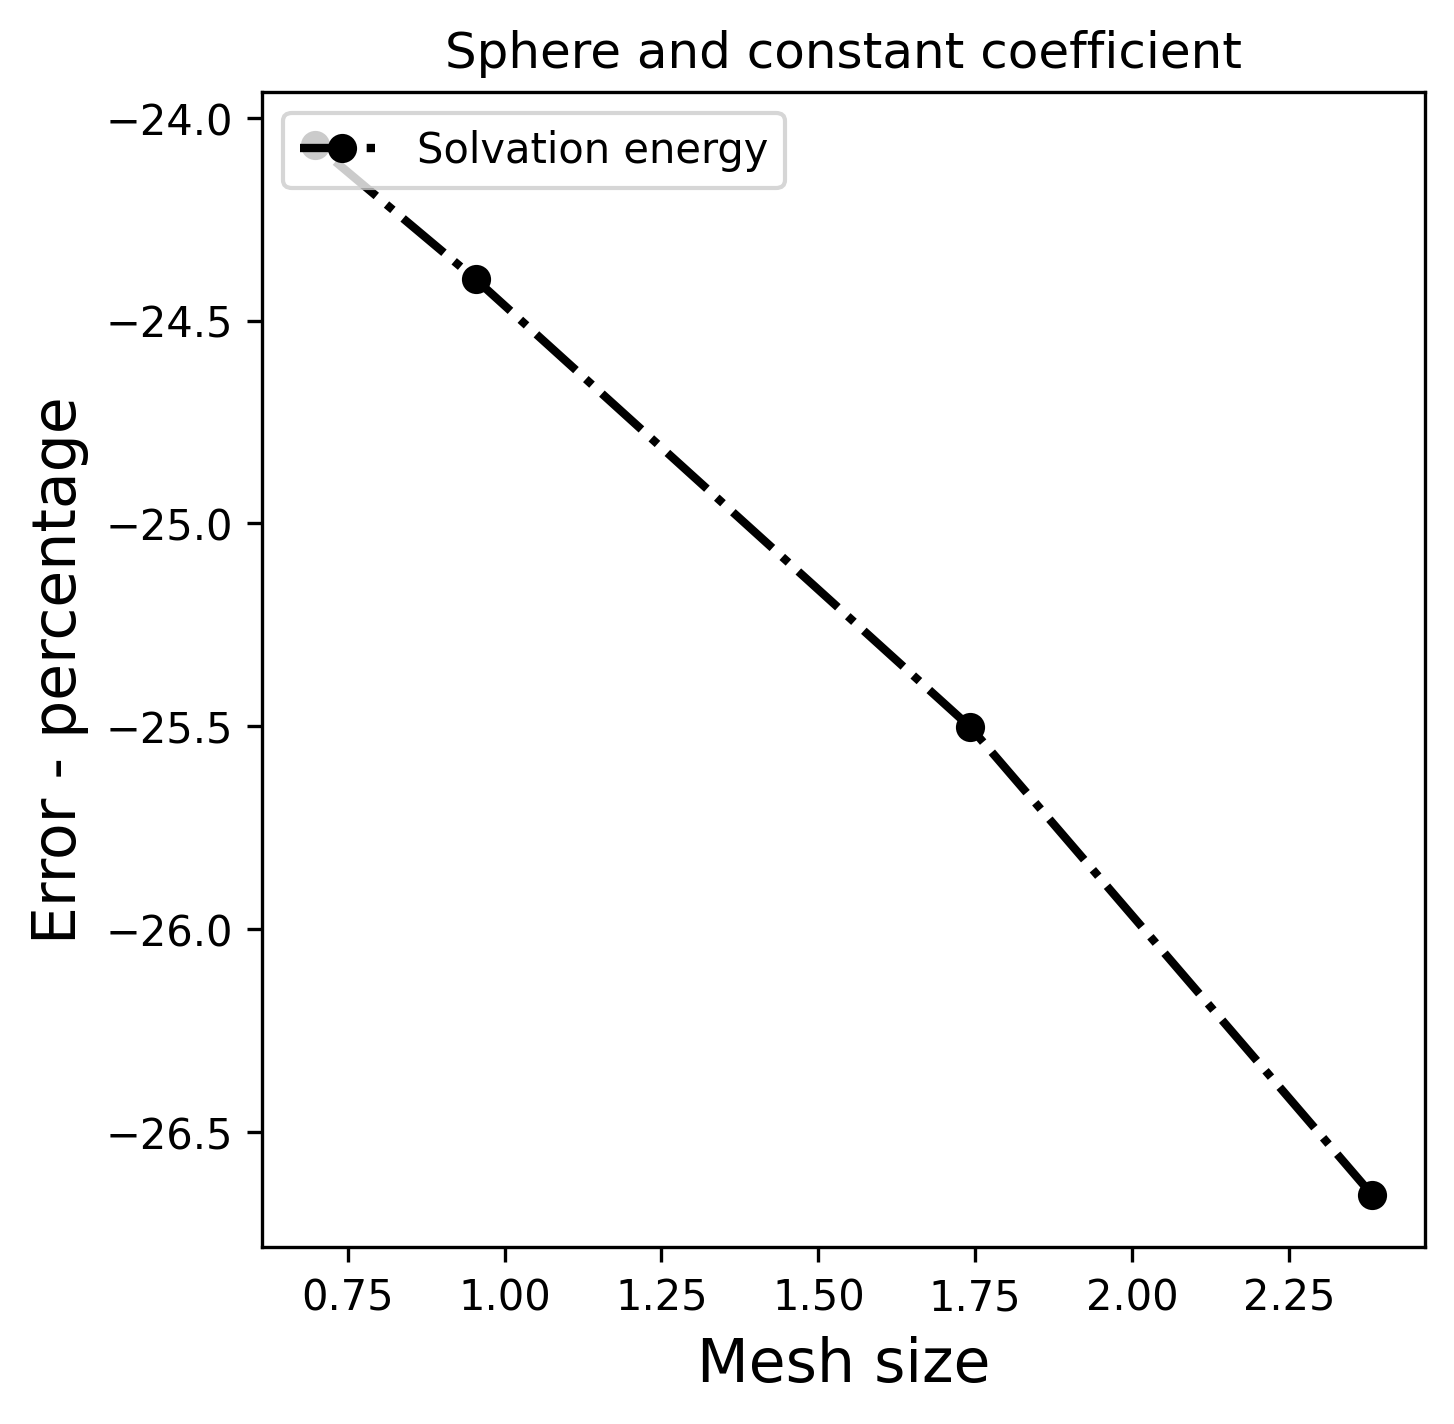

In [4]:
from operator import add
import matplotlib.pyplot as plt

with open('FEM_BEM_Sphere_Const_error.npy', 'wb') as f:
    np.save(f, np.array(solv_error))

plt.figure( figsize=(5, 5), dpi=300)
plt.plot(mesh_size, solv_error, 'ko-.', linewidth=2, label='Solvation energy')
# plt.loglog(mesh_size, o_mesh_size, 'k:', linewidth=1, label='O(h)')
plt.legend(loc='upper left')
plt.title('Sphere and constant coefficient')
plt.xlabel('Mesh size', fontsize='x-large')
plt.ylabel('Error - percentage', fontsize='x-large')
plt.show()

## Iteration count

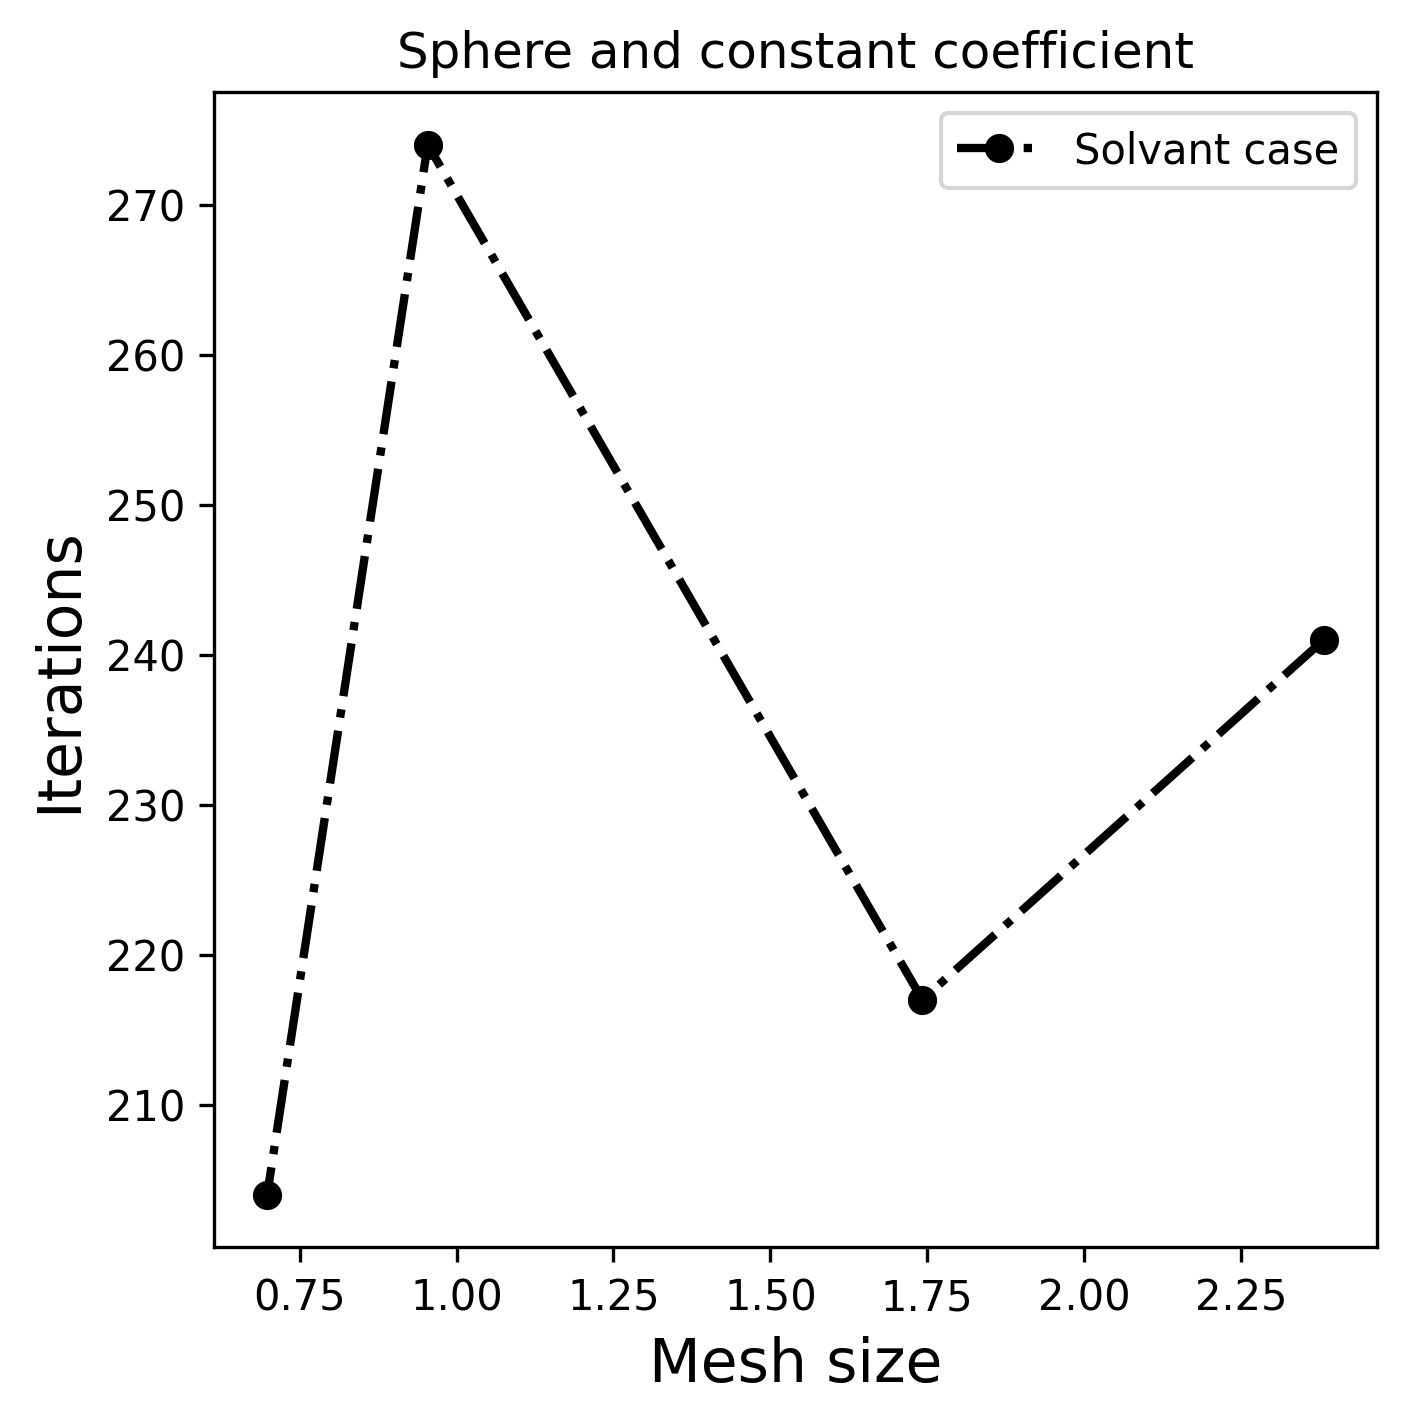

In [5]:
import matplotlib.pyplot as plt

log_mesh_size = np.log(mesh_size)

with open('FEM_BEM_Sphere_Const_iter.npy', 'wb') as f:
    np.save(f, np.array(iter_num))

plt.figure( figsize=(5, 5), dpi=300)
plt.plot(mesh_size, iter_num, 'ko-.', linewidth=2, label='Solvant case')
plt.legend(loc='upper right')
plt.title('Sphere and constant coefficient')
plt.xlabel('Mesh size', fontsize='x-large')
plt.ylabel('Iterations', fontsize='x-large')
plt.show()

## Computational cost

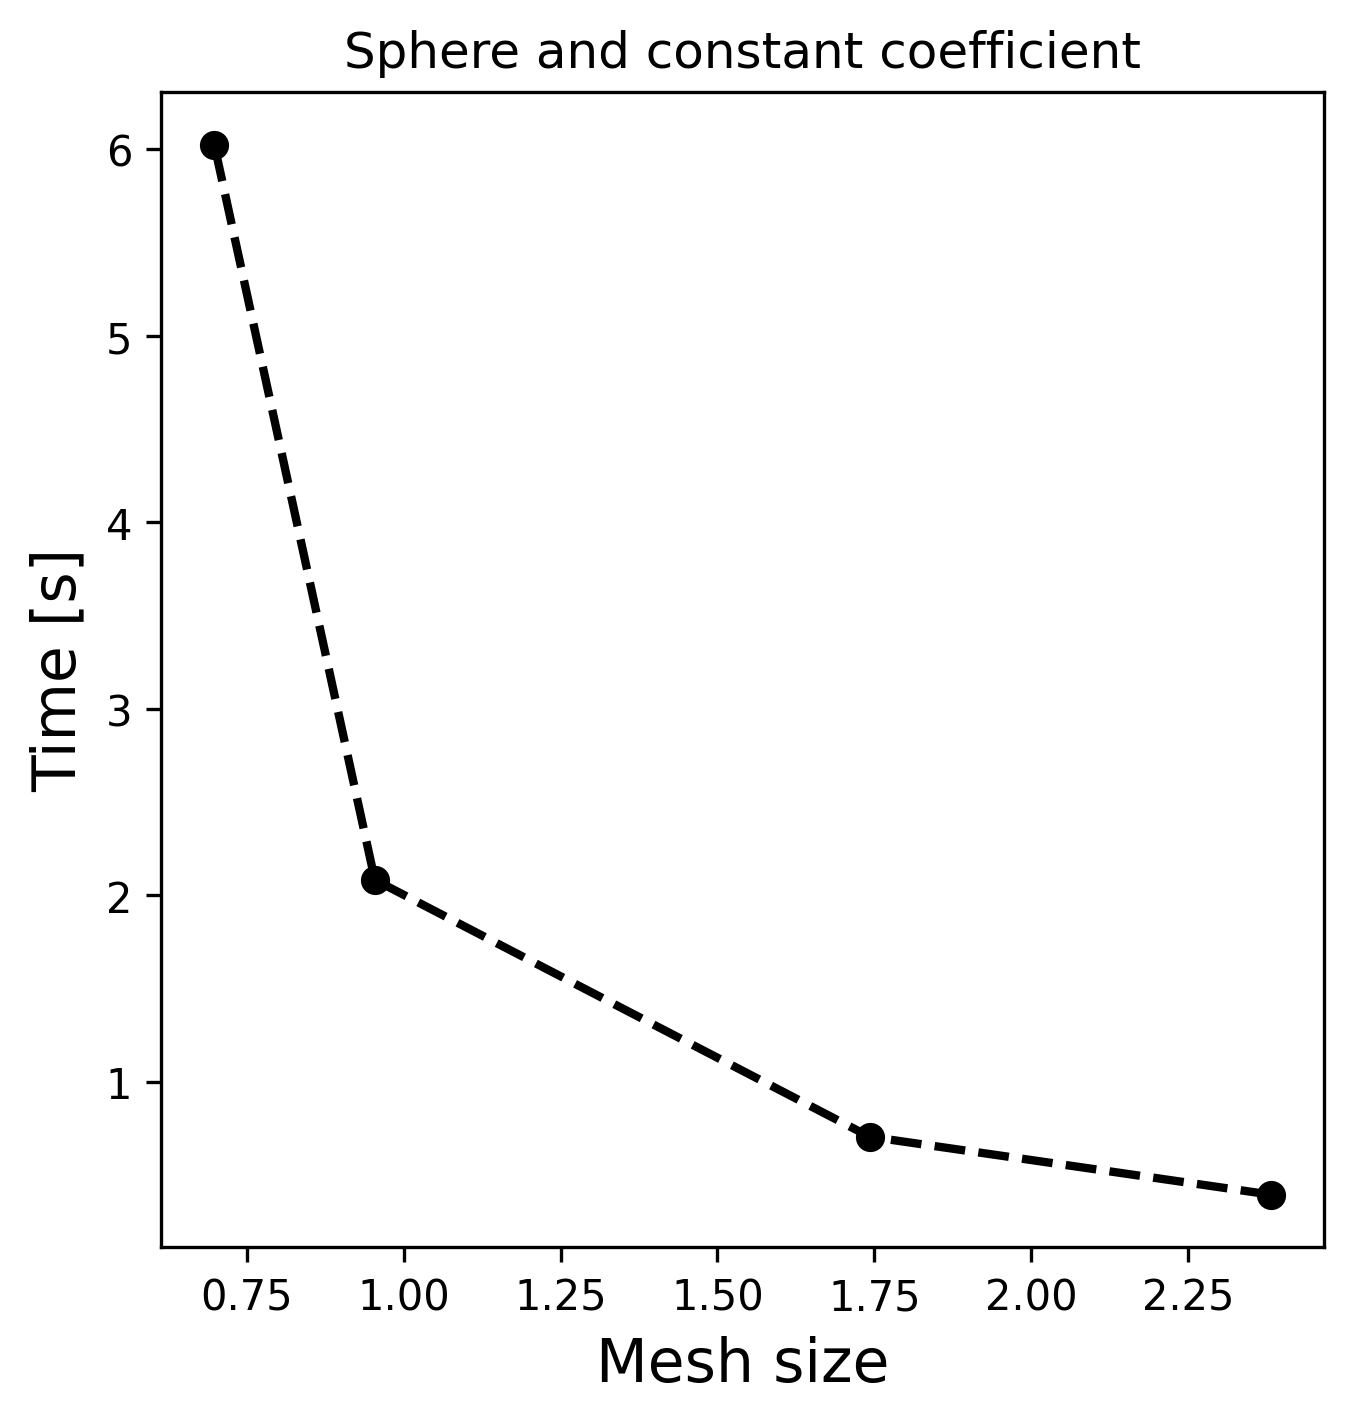

In [6]:
import matplotlib.pyplot as plt

log_mesh_size = np.log(mesh_size)

with open('FEM_BEM_Sphere_Const_time.npy', 'wb') as f:
    np.save(f, np.array(time_solve))

plt.figure( figsize=(5, 5), dpi=300)
# plt.plot(mesh_size, np.add(time_solve, vac_time_solve), 'ko--', linewidth=2)
plt.plot(mesh_size, time_solve, 'ko--', linewidth=2, label='Solvant case')
plt.title('Sphere and constant coefficient')
plt.xlabel('Mesh size', fontsize='x-large')
plt.ylabel('Time [s]', fontsize='x-large')
plt.show()

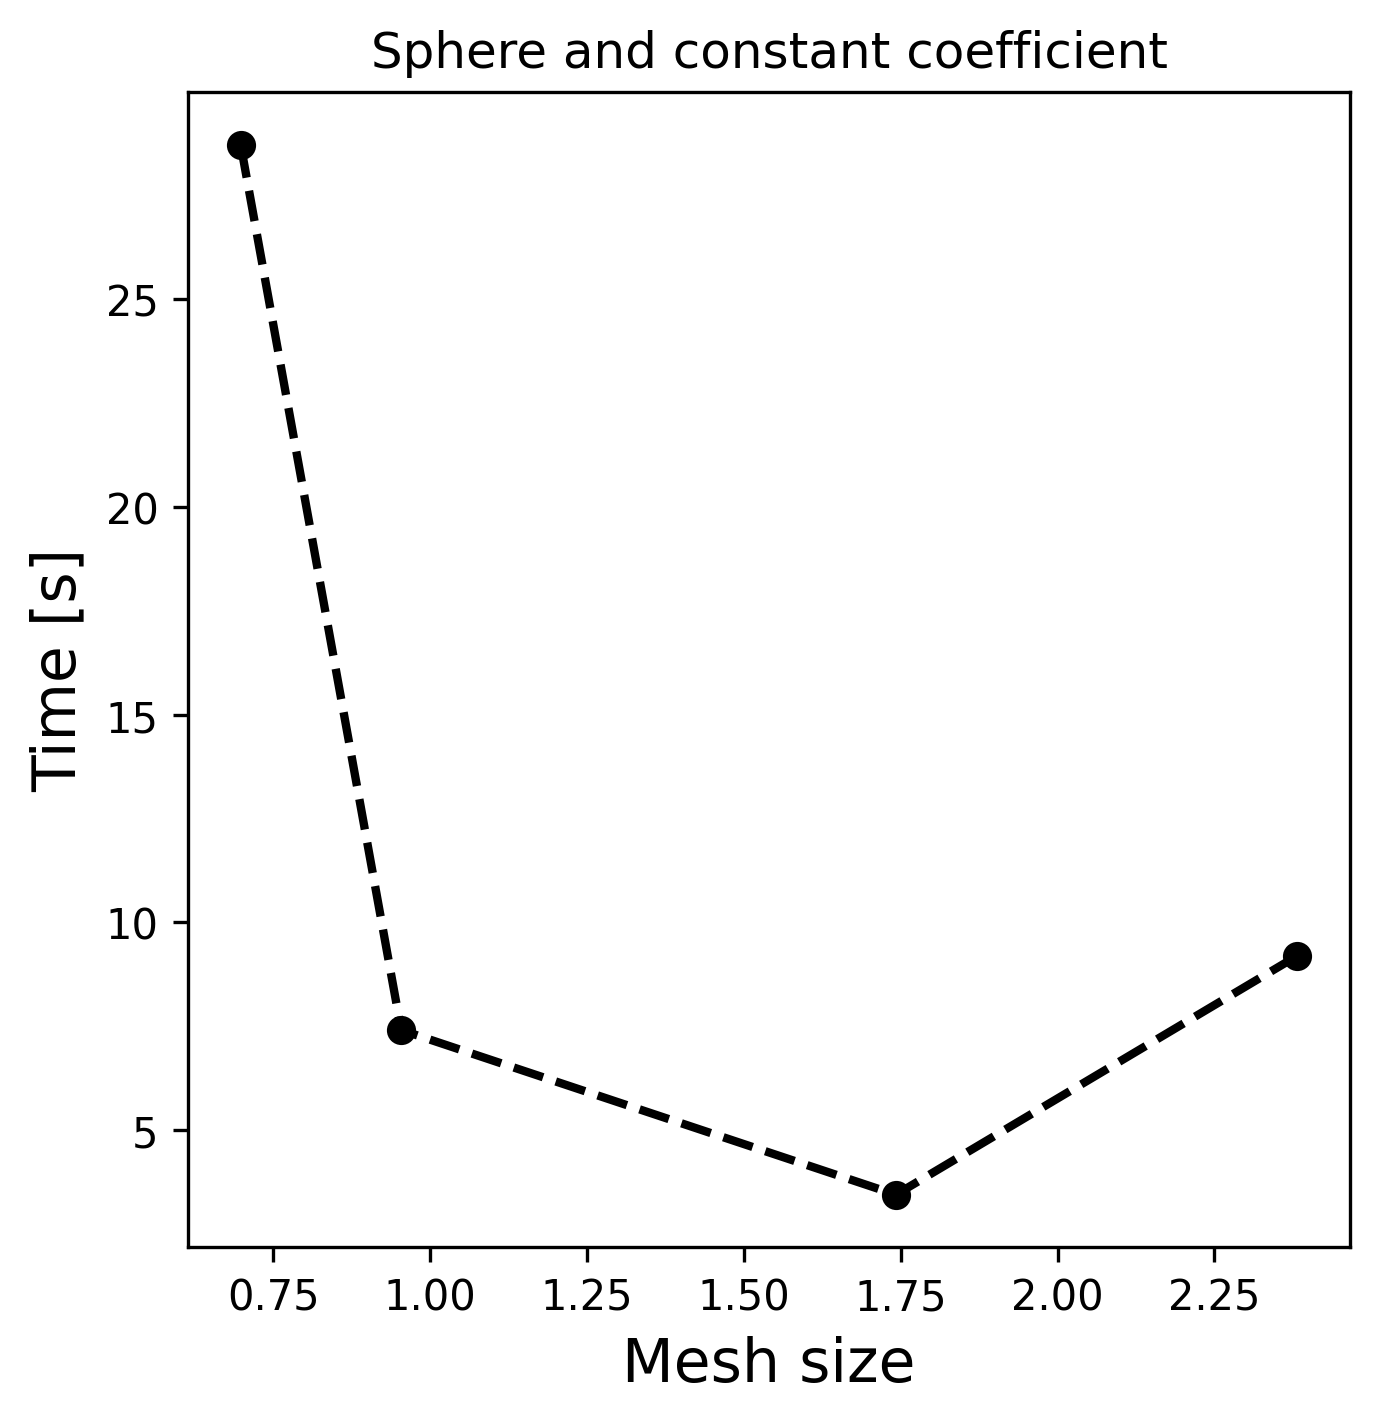

In [7]:
import matplotlib.pyplot as plt

log_mesh_size = np.log(mesh_size)

with open('FEM_BEM_Sphere_Const_time_assemble.npy', 'wb') as f:
    np.save(f, np.array(time_solve))

plt.figure( figsize=(5, 5), dpi=300)
# plt.plot(mesh_size, np.add(time_solve, vac_time_solve), 'ko--', linewidth=2)
plt.plot(mesh_size, time_set, 'ko--', linewidth=2, label='Solvant case')
plt.title('Sphere and constant coefficient')
plt.xlabel('Mesh size', fontsize='x-large')
plt.ylabel('Time [s]', fontsize='x-large')
plt.show()